In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

from imblearn.over_sampling import SMOTE

In [28]:
data = pd.read_csv("adult_dataset.csv")

data.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [29]:
data.info()
data.describe(include='all')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32561 non-null  int64 
 1   workclass       32561 non-null  object
 2   fnlwgt          32561 non-null  int64 
 3   education       32561 non-null  object
 4   education-num   32561 non-null  int64 
 5   marital-status  32561 non-null  object
 6   occupation      32561 non-null  object
 7   relationship    32561 non-null  object
 8   race            32561 non-null  object
 9   sex             32561 non-null  object
 10  capital-gain    32561 non-null  int64 
 11  capital-loss    32561 non-null  int64 
 12  hours-per-week  32561 non-null  int64 
 13  native-country  32561 non-null  object
 14  income          32561 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
count,32561.000000,32561,3.256100e+04,32561,32561.000000,32561,32561,32561,32561,32561,32561.000000,32561.000000,32561.000000,32561,32561
unique,NaN,9,NaN,16,NaN,7,15,6,5,2,NaN,NaN,NaN,42,2
top,NaN,Private,NaN,HS-grad,NaN,Married-civ-spouse,Prof-specialty,Husband,White,Male,NaN,NaN,NaN,United-States,<=50K
freq,NaN,22696,NaN,10501,NaN,14976,4140,13193,27816,21790,NaN,NaN,NaN,29170,24720
mean,38.581647,NaN,1.897784e+05,NaN,10.080679,NaN,NaN,NaN,NaN,NaN,1077.648844,87.303830,40.437456,NaN,NaN
std,13.640433,NaN,1.055500e+05,NaN,2.572720,NaN,NaN,NaN,NaN,NaN,7385.292085,402.960219,12.347429,NaN,NaN
min,17.000000,NaN,1.228500e+04,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,1.000000,NaN,NaN
25%,28.000000,NaN,1.178270e+05,NaN,9.000000,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,40.000000,NaN,NaN
50%,37.000000,NaN,1.783560e+05,NaN,10.000000,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,40.000000,NaN,NaN
75%,48.000000,NaN,2.370510e+05,NaN,12.000000,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,45.000000,NaN,NaN


In [30]:
data.isnull().sum()

age               0
workclass         0
fnlwgt            0
education         0
education-num     0
marital-status    0
occupation        0
relationship      0
race              0
sex               0
capital-gain      0
capital-loss      0
hours-per-week    0
native-country    0
income            0
dtype: int64

In [31]:
for col in data.columns:
    if data[col].isnull().sum() > 0:
        data[col].fillna(data[col].mode()[0], inplace=True)

In [32]:
num_cols = data.select_dtypes(include=['int64', 'float64']).columns

for col in num_cols:
    Q1 = data[col].quantile(0.25)
    Q3 = data[col].quantile(0.75)
    IQR = Q3 - Q1

    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR

    data[col] = np.where(data[col] < lower, lower,
                np.where(data[col] > upper, upper, data[col]))

In [63]:
le = LabelEncoder()
data_encoded = data.copy()

for col in data.columns:
    if data[col].dtype == 'object':
        data_encoded[col] = le.fit_transform(data[col])

In [64]:
# Scale numeric columns to avoid Logistic Regression warning
numeric_cols = ['age','fnlwgt','education-num','capital-gain','capital-loss','hours-per-week']
scaler = StandardScaler()
X_train[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])
X_test[numeric_cols] = scaler.transform(X_test[numeric_cols])

In [65]:
X = data_encoded.drop('income', axis=1)
y = data_encoded['income']

In [66]:
df['income'] = df['income'].map({'<=50K': 0, '>50K': 1})

OBJECTIVE 1: FINANCIAL INCLUSION ANALYSIS

Problem: Banks need fair credit assessment across demographics

Solution: Analyze income patterns by demographic groups

In [97]:
#Gender-wise income distribution
gender_income = pd.crosstab(data['sex'], data['income'], normalize='index') * 100
gender_income

income,<=50K,>50K
sex,,
Female,89.053941,10.946059
Male,69.426342,30.573658


In [96]:
#Race-wise income distribution
race_income = pd.crosstab(data['race'], data['income'], normalize='index') * 100
race_income

income,<=50K,>50K
race,,
Amer-Indian-Eskimo,88.424437,11.575563
Asian-Pac-Islander,73.435996,26.564004
Black,87.612036,12.387964
Other,90.774908,9.225092
White,74.414006,25.585994


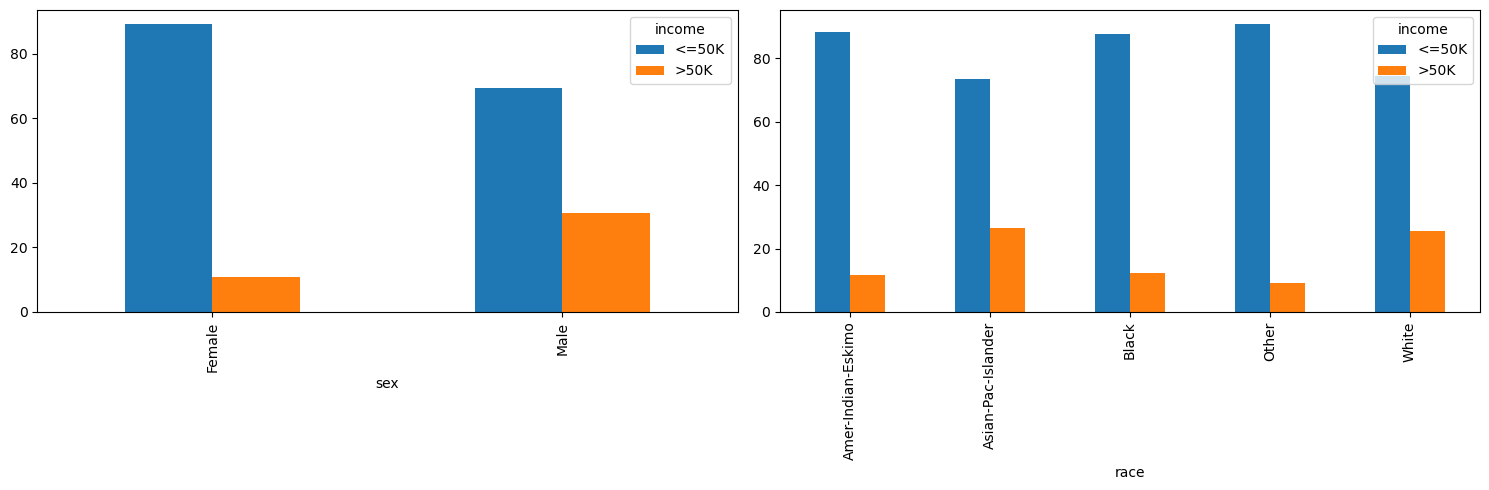

In [95]:
#Plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
gender_income.plot(kind='bar', ax=ax1)
race_income.plot(kind='bar', ax=ax2)
plt.tight_layout()
plt.show()

=== OBJECTIVE 2: HR SALARY BENCHMARKING ===

Problem: Companies need data-driven salary benchmarking

Solution: Analyze salary patterns by job-related factors

In [94]:
#Education vs income
edu_income = pd.crosstab(data['education'], data['income'], normalize='index') * 100
edu_income_sorted = edu_income.sort_values('>50K', ascending=False)
edu_income_sorted

income,<=50K,>50K
education,,
Doctorate,25.907990,74.092010
Prof-school,26.562500,73.437500
Masters,44.341265,55.658735
Bachelors,58.524743,41.475257
Assoc-voc,73.878437,26.121563
Assoc-acdm,75.164011,24.835989
Some-college,80.976546,19.023454
HS-grad,84.049138,15.950862
12th,92.378753,7.621247


In [93]:
#Work hours analysis
data.groupby('income')['hours-per-week'].describe()

,count,mean,std,min,25%,50%,75%,max
income,,,,,,,,
<=50K,24720.0,40.257969,5.936666,32.5,35.0,40.0,40.0,52.5
>50K,7841.0,44.180079,6.014409,32.5,40.0,40.0,50.0,52.5


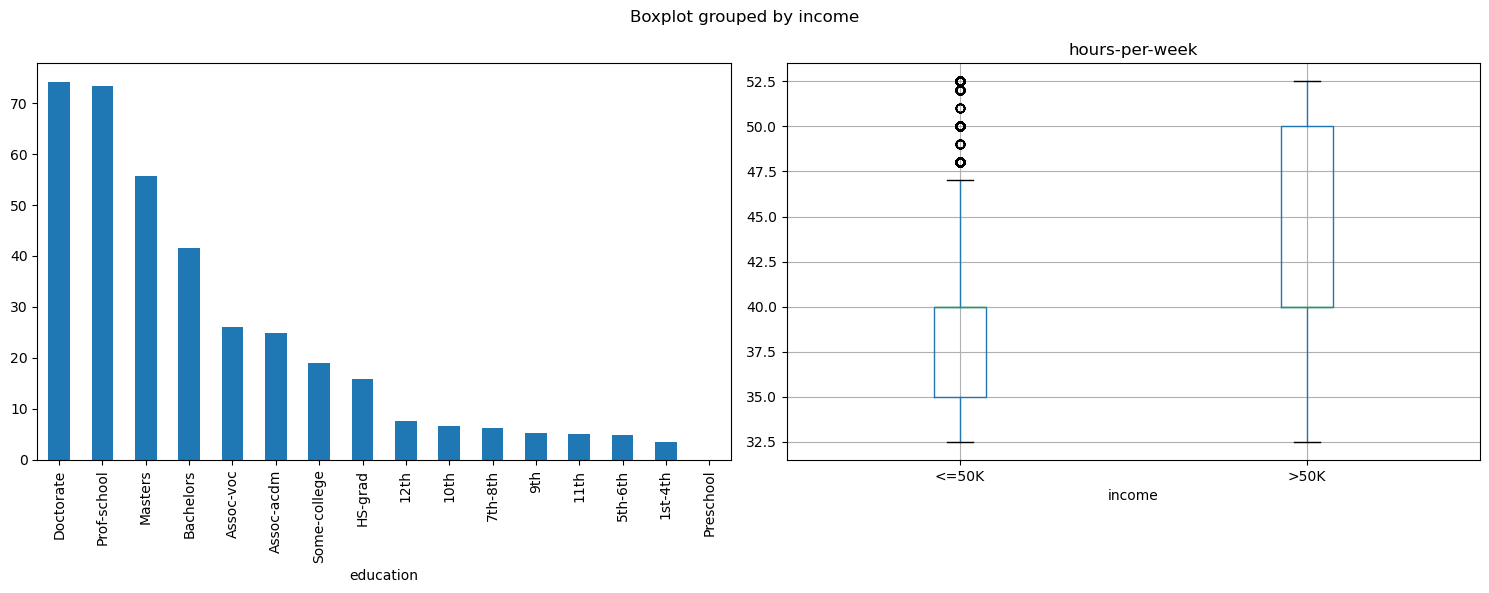

In [92]:
#Plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
edu_income_sorted['>50K'].plot(kind='bar', ax=ax1)
data.boxplot(column='hours-per-week', by='income', ax=ax2)
plt.tight_layout()
plt.show()

=== OBJECTIVE 3: SOCIAL POLICY OPTIMIZATION ===

Problem: Government needs to identify at-risk populations

Solution: Identify demographic groups with high low-income rates

In [73]:
#Age groups creation
data['age_group'] = pd.cut(
    data['age'],
    bins=[0, 25, 35, 45, 55, 100],
    labels=['18-25', '26-35', '36-45', '46-55', '55+']
)
age_income = pd.crosstab(data['age_group'], data['income'], normalize='index') * 100
age_income

income,<=50K,>50K
age_group,,
18-25,98.221806,1.778194
26-35,81.313131,18.686869
36-45,65.363966,34.636034
46-55,60.166125,39.833875
55+,71.729029,28.270971


In [74]:
#High-risk education groups
edu_risk = pd.crosstab(data['education'], data['income'], normalize='index')['<=50K'] * 100
high_risk_edu = edu_risk[edu_risk > 60].sort_values(ascending=False)
high_risk_edu

education
Preschool       100.000000
1st-4th          96.428571
5th-6th          95.195195
11th             94.893617
9th              94.747082
7th-8th          93.808050
10th             93.354770
12th             92.378753
HS-grad          84.049138
Some-college     80.976546
Assoc-acdm       75.164011
Assoc-voc        73.878437
Name: <=50K, dtype: float64

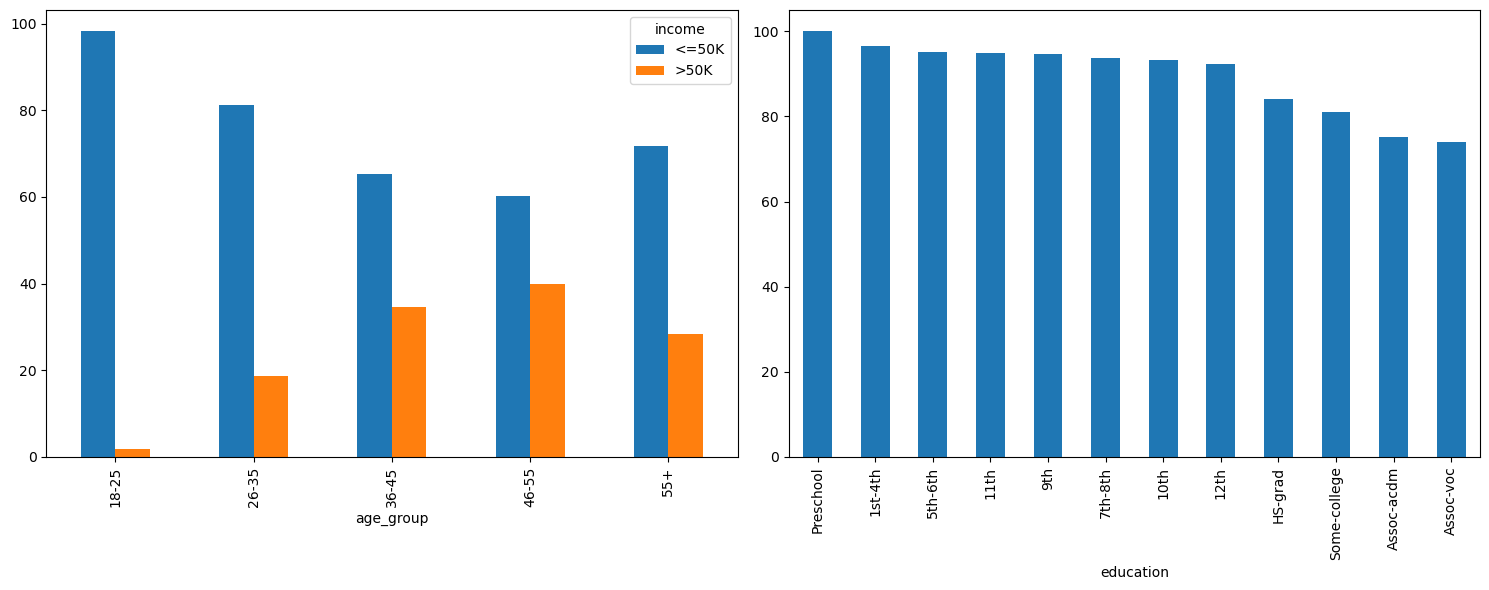

In [75]:
#PLOTS
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
age_income.plot(kind='bar', ax=ax1)
high_risk_edu.plot(kind='bar', ax=ax2)
plt.tight_layout()
plt.show()

=== OBJECTIVE 4: CAREER GUIDANCE ===

Problem: People need data-driven career advice

Solution: Identify most important factors for high income

In [76]:
#One-hot encoding
X_encoded = pd.get_dummies(X)

In [77]:
#Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y, test_size=0.2, random_state=42
)

In [78]:
#Train Random Forest for feature importance
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [79]:
#Feature importance
feat_imp = pd.DataFrame({
    'feature': X_encoded.columns,
    'importance': rf.feature_importances_
}).sort_values('importance', ascending=False)

feat_imp.head(10)

,feature,importance
2,fnlwgt,0.208367
0,age,0.143511
7,relationship,0.107870
4,education-num,0.105557
6,occupation,0.089244
12,hours-per-week,0.080211
5,marital-status,0.073720
1,workclass,0.051938
3,education,0.042696
13,native-country,0.020840


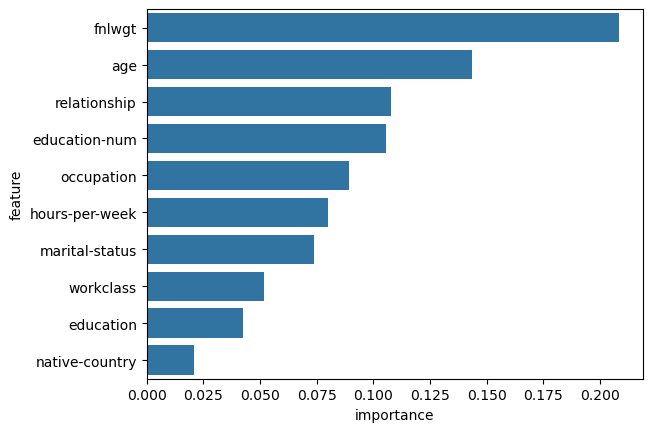

In [80]:
#PLOT
sns.barplot(data=feat_imp.head(10), x='importance', y='feature')
plt.show()

=== OBJECTIVE 5: ECONOMIC RESEARCH ===

Problem: Need evidence-based insights on income inequality

Solution: Build predictive models and analyze bias

In [87]:
# Train Models
models = {
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "Logistic Regression": LogisticRegression(max_iter=2000)  # increase max_iter
}

results = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    results[name] = accuracy_score(y_test, preds)

results

{'Random Forest': 0.8314140948871488,
 'Logistic Regression': 0.8119146322739137}

In [88]:
#Bias analysis (Gender)
best_model_name = max(results, key=results.get)
best_model = models[best_model_name]
best_pred = best_model.predict(X_test)

test_df = data.iloc[X_test.index].copy()
test_df['actual'] = y_test.values
test_df['predicted'] = best_pred

In [89]:
#Gender bias
test_df.groupby('sex')[['actual', 'predicted']].mean()

,actual,predicted
sex,,
Female,0.109595,0.078081
Male,0.304992,0.266469


In [90]:
#Gender-wise accuracy
gender_accuracy = test_df.groupby('sex')[['actual','predicted']].apply(
    lambda x: (x['actual'] == x['predicted']).mean()
)
gender_accuracy

sex
Female    0.911101
Male      0.792797
dtype: float64

In [91]:
#Income Prediction Function
def predict_income(age, education, hours_per_week, sex):
    score = 0

    edu_scores = {
        'Doctorate': 40, 'Masters': 35, 'Bachelors': 30,
        'Some-college': 20, 'HS-grad': 15, 'Assoc-acdm': 25,
        'Assoc-voc': 22, 'Prof-school': 38
    }
    score += edu_scores.get(education, 10)

    if 30 <= age <= 55:
        score += 20
    elif age > 55:
        score += 15

    if hours_per_week >= 40:
        score += 15

    if sex == 'Male':
        score += 10

    prediction = ">50K" if score >= 50 else "<=50K"
    confidence = min(score * 1.5, 100)

    return prediction, confidence